In [1]:
import fiona
import requests
import matplotlib
import numpy as np
import pandas as pd
from lxml import etree
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from mpl_toolkits.basemap import Basemap
import mpl_toolkits.basemap.pyproj as pyproj
from matplotlib.colors import Normalize
from matplotlib.collections import PatchCollection
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon, shape
from shapely.prepared import prep
from descartes import PolygonPatch
from itertools import chain
from utils import cmap_discretize, colorbar_index
%matplotlib inline

In [2]:
indonensia_df = pd.read_csv("../data/indonesia_education-country.csv")
indonensia_df.columns

Index([u'kode_provinsi', u'nama_provinsi', u'kode_kabkota', u'nama_kabkota',
       u'tingkat_pendidikan', u'jumlah_laki_laki', u'jumlah_perempuan',
       u'latitude', u'longitude'],
      dtype='object')

In [3]:
indonensia_city_df = indonensia_df[["nama_kabkota", "latitude", "longitude"]]

## Get shape file

download indonesia gis shape files from [here](https://ordercitrasatelit.wordpress.com/2013/03/16/free-peta-batas-administrasi-desa-seluruh-indonesia/)

In [4]:
shp = fiona.open('../data/indonesia_gis/DesaIndonesia.shp')
crs_data = shp.crs
bds = shp.bounds
shp.close()
extra = 0.01

# bounds need to be datum-shifted
wgs84 = pyproj.Proj("+init=EPSG:4326")
osgb36 = pyproj.Proj("+init=EPSG:27700")
ll = pyproj.transform(osgb36, wgs84, bds[0], bds[1])
ur = pyproj.transform(osgb36, wgs84, bds[2], bds[3])
ll = (bds[0], bds[1])
ur = (bds[2], bds[3])
coords = list(chain(ll, ur))
w, h = coords[2] - coords[0], coords[3] - coords[1]

## Create basemap open shape file

(66290,
 5,
 [95.010063, -11.00214, 0.0, 0.0],
 [141.007187, 5.754763, 0.0, 0.0],
 <matplotlib.collections.LineCollection at 0x12f7e0450>)

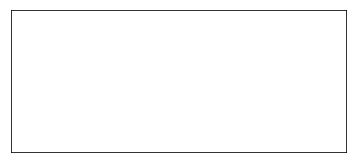

In [5]:
m = Basemap(
    projection='tmerc',
    lon_0 = 145,
    lat_0 = -10,
    ellps = 'WGS84',
    llcrnrlon=coords[0] - extra * w,
    llcrnrlat=coords[1] - extra + 0.01 * h,
    urcrnrlon=coords[2] + extra * w,
    urcrnrlat=coords[3] + extra + 0.01 * h,
    lat_ts=0,
    resolution='i',
    suppress_ticks=True)
m.readshapefile(
    '../data/indonesia_gis/DesaIndonesia',
    'indonesia',
    color='none',
    zorder=2)

In [6]:
# select plot font
#fm.findSystemFonts()

In [7]:
# plot font
fm.findSystemFonts(fontpaths='/Library/Fonts/', fontext='ttf')
prop = fm.FontProperties(fname='/Library/Fonts/Times New Roman.ttf')

In [8]:
# set up a map dataframe
df_map = pd.DataFrame({
    'poly': [Polygon(xy) for xy in m.indonesia],
    'village': [w['DESA'] for w in m.indonesia_info],
})
df_map['area_m'] = df_map['poly'].map(lambda x: x.area)
df_map['area_km'] = df_map['area_m'] / 100000
df_map['village'] = df_map['village'].str.strip()

# Create Point objects in map coordinates from dataframe lon and lat values
map_points = pd.Series(
    [Point(m(mapped_x, mapped_y)) for mapped_x, mapped_y in zip(indonensia_city_df['longitude'],
                                                                indonensia_city_df['latitude'])])
city_points = MultiPoint(list(map_points.values))
indonesia_polygon = prep(MultiPolygon(list(df_map['poly'].values)))

# calculate points that fall within the Indonesia shapefile boundary
city_points_filter = filter(indonesia_polygon.contains, city_points)

/Users/kivan/anaconda3/envs/gl-env/lib/python2.7/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/kivan/anaconda3/envs/gl-env/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/kivan/anaconda3/envs/gl-env/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/Users/kivan/anaconda3/envs/gl-env/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/kivan/anaconda3/envs/gl-env/lib/python2.7/site-packages/mpl_toolkits/base

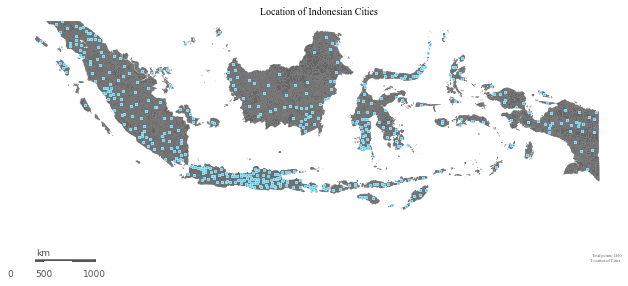

In [9]:
# draw patches from polygons
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(
    x, fc='#555555', ec='#787878', lw=.25, alpha=.9
    , zorder=4))

plt.clf()
fig = plt.figure()

ax = fig.add_subplot(111, axisbg='w', frame_on=False)

# we don't need to pass points to m() because we calculated using map_points and shapefile polygons
dev = m.scatter(
    [geom.x for geom in city_points_filter],
    [geom.y for geom in city_points_filter],
    5, marker='o', lw=.25,
    facecolor='#33ccff', edgecolor='w',
    alpha=0.9, antialiased=True,
    label='Village Locations', zorder=3)

# plot cities by adding the PatchCollection to the axes instance
ax.add_collection(PatchCollection(df_map['patches'].values, match_original=True))

# copyright and source data info
smallprint = ax.text(
    1.03, 0,
    'Total points: %s\nLocation of Cities ' % len(city_points_filter),
    ha='right', va='bottom',
    size=4,
    color='#555555',
    transform=ax.transAxes,
    fontproperties=prop,
)

# Draw a map scale
m.drawmapscale(
    coords[0] + 0.08, coords[1] + 0.015,
    coords[0], coords[1],
    1000.,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#555555',
    fontcolor='#555555',
    zorder=5
)
plt.title("Location of Indonesian Cities", fontproperties=prop)
plt.tight_layout()
fig.set_size_inches(8.47, 5.25)
plt.savefig('../figures/indonesian_cities.png', dpi=300, alpha=True)
plt.show()

In [10]:
import time
print("last updated: {}".format(time.strftime("%a, %d %b %Y %H:%M", time.localtime())))

last updated: Sun, 20 Aug 2017 19:51
